# Pathway associated gene expression heatmap

This notebook will use heatmaps to visualize the gene expression for selected genes that correspond to selected pathways. These pathways have been selected for their roles in tumor proliferation and chemotherapy resistance.

1. Tumor Proliferation
    1. G2/M Cell Cycle Checkpoint
    2. E2F Regulation
2. Chemotherapy Resistance
    1. DNA Damage Response (DDR)
    2. Unfolded Protein Response (UPR)

For these heatmaps, the combined epethilial dataset does **not** filter out the following:

* Stromal cells
   * This cell type is located in connective tissues. [9]
   * "Source of cancer-associated fibroblasts" [9, 10]
* Genes with low variance across cells
   * The two types of cells being analyzed have different descriptive statistics which contributes to the likelihood that filtering out highly variable genes for each of these groups will be more difficult to compare.
   * The interest in this notebook is biolical signifcance and/or relevance. Keeping these genes ensures that key insights aren't missed just because they don't drive variance across all the cells.

## 0. Initializations

In [1]:
# -- imports --
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from signals_in_the_noise.preprocessing.gse161529 import GSE161529
from signals_in_the_noise.utilities.storage import get_resources_path
from signals_in_the_noise.utilities.visualization import get_figure_axes

In [2]:
# -- datasets --
gse = GSE161529()

2025-08-02 18:29:10,095 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909253_N-PM0092-Total.h5ad as AnnData object.
2025-08-02 18:29:10,191 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909254_N-PM0019-Total.h5ad as AnnData object.
2025-08-02 18:29:10,368 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909255_N-N280-Epi.h5ad as AnnData object.
2025-08-02 18:29:10,420 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909256_N-PM0095-Epi.h5ad as AnnData object.
2025-08-02 18:29:10,587 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909257_N-PM0095-Total.h5ad 

In [3]:
all_real, all_noise = gse.get_combined_epithilial_dataset(
    real_filename="combined_epi_normal_pathway_real.h5ad",
    noise_filename="combined_epi_normal_pathway_noise.h5ad",
    remove_stromal=False,
)

2025-08-02 18:29:21,982 [INFO] signals_in_the_noise.preprocessing.gse161529: Loading combined datasets...


In [4]:
tumor_proliferation_genes = list(gse.G2M_CHECKPOINT_GENES.values())
tumor_proliferation_genes.extend(list(gse.E2F_REGULATION_GENES.values()))

chemo_resistance_genes = list(gse.DDR_GENES.values())
chemo_resistance_genes.extend(list(gse.UPR_GENES.values()))

In [5]:
# -- data set up --
pathway_to_gmt = {
    'ddr': 'HALLMARK_DNA_REPAIR.v2025.1.Hs.gmt',
    'e2f': 'HALLMARK_E2F_TARGETS.v2025.1.Hs.gmt',
    'g2m': 'HALLMARK_G2M_CHECKPOINT.v2025.1.Hs.gmt',
    'upr': 'HALLMARK_UNFOLDED_PROTEIN_RESPONSE.v2025.1.Hs.gmt',
}
resources_subdirectory = 'gene_set_enrichment_analysis'
combined_pathways_filename = "/".join([gse.STUDY_ID, 'gene_set_enrichment_analysis', 'combined_gene_sets.gmt'])
combined_pathway_path = get_resources_path(combined_pathways_filename)

if not combined_pathway_path.exists():
    with open(combined_pathway_path, 'w') as output_file:
        for gmt_file in pathway_to_gmt.values():
            gmt_path = get_resources_path("/".join([gse.STUDY_ID, 'gene_set_enrichment_analysis', gmt_file]))
            with open(gmt_path, 'r') as input_file:
                content = input_file.read()
                output_file.write(content)
                output_file.write('\n')

In [6]:
import gseapy as gp

gene_sets = gp.parser.read_gmt(str(combined_pathway_path))

2025-08-02 18:30:06,625 [INFO] root: User Defined gene sets is given.......continue..........


In [9]:
# Cacluate DE
all_data = ad.concat([all_real, all_noise], join='inner')
all_data.obs['is_noise'] = all_data.obs['is_noise'].map({1: 'noise', 0: 'real'})

In [10]:
all_data.obs['is_noise']

GSM4909260_N-N1105-Epi.h5ad_0        real
GSM4909260_N-N1105-Epi.h5ad_1        real
GSM4909260_N-N1105-Epi.h5ad_2        real
GSM4909260_N-N1105-Epi.h5ad_3        real
GSM4909260_N-N1105-Epi.h5ad_4        real
                                    ...  
GSM4909273_N-MH275-Epi.h5ad_6284    noise
GSM4909273_N-MH275-Epi.h5ad_6304    noise
GSM4909273_N-MH275-Epi.h5ad_6309    noise
GSM4909273_N-MH275-Epi.h5ad_6364    noise
GSM4909273_N-MH275-Epi.h5ad_6400    noise
Name: is_noise, Length: 58830, dtype: object

In [11]:
sc.tl.rank_genes_groups(
    all_data,
    groupby='is_noise',
    # group 1 - is noise cell
    groups=['noise'],
    # group 0 - is real cell
    reference='real',
    method='wilcoxon',
    # test all genes
    n_genes=all_data.shape[1],
)

... storing 'is_noise' as categorical


In [12]:
# Extract DE results: genes and scores (e.g., log fold change or scores)
de_results = all_data.uns['rank_genes_groups']
de_results

{'params': {'groupby': 'is_noise',
  'reference': 'real',
  'method': 'wilcoxon',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('MT-ATP8',), ('MT-ND3',), ('MT-CO2',), ..., ('PTMA',),
            ('RPL41',), ('RPL15',)],
           dtype=[('noise', 'O')]),
 'scores': rec.array([(   9.612901,), (   7.449432,), (   5.87423 ,), ...,
            (-109.2315  ,), (-109.67778 ,), (-110.0455  ,)],
           dtype=[('noise', '<f4')]),
 'pvals': rec.array([(7.05331102e-22,), (9.37430746e-14,), (4.24813727e-09,), ...,
            (0.00000000e+00,), (0.00000000e+00,), (0.00000000e+00,)],
           dtype=[('noise', '<f8')]),
 'pvals_adj': rec.array([(5.23233676e-21,), (5.86558813e-13,), (2.31665086e-08,), ...,
            (0.00000000e+00,), (0.00000000e+00,), (0.00000000e+00,)],
           dtype=[('noise', '<f8')]),
 'logfoldchanges': rec.array([( 0.4040392 ,), ( 0.19732916,), ( 0.03322844,), ...,
            (-3.4181743 ,), (-3.6209111 ,), (-3.5

In [13]:
genes_df = de_results['names']['noise']
scores_df = de_results['logfoldchanges']['noise']
de_df = pd.DataFrame({'gene': genes_df, 'score': scores_df})
de_df.sample(20)

,gene,score
1774,TRIM15,0.155712
20115,TTC21A,-1.136822
12988,AL592295.3,-16.046017
5218,AC026904.4,0.000000
3528,AC094104.1,0.000000
25885,GAS8,-2.173217
168,LINC00887,0.086924
8406,IGHVII-49-1,0.000000
18478,AC023908.3,-1.767621
28237,YLPM1,-1.962842


In [14]:
de_df.describe()

,score
count,33538.000000
mean,-4.098438
std,5.734011
min,-21.177273
25%,-3.093899
50%,-2.166607
75%,-0.582468
max,18.596149


In [15]:
# GSEA requires a gene list ranked by a metric (e.g., log fold change)
# Remove NaNs and duplicates if any
de_df = de_df.dropna().drop_duplicates(subset='gene')
de_df = de_df.sort_values('score', ascending=False)
de_df.describe()

,score
count,33538.000000
mean,-4.098438
std,5.734011
min,-21.177273
25%,-3.093899
50%,-2.166607
75%,-0.582468
max,18.596149


In [16]:
ranked_genes_df = de_df.set_index('gene')['score']
ranked_genes_df

gene
TMEM72        18.596149
LINC01779     18.534569
CD3D          18.510317
AL590079.1    18.241653
AC009652.1    18.087940
                ...    
PRG4         -20.685488
CYP26B1      -20.772860
KRT75        -20.794336
MIR9-3HG     -20.942411
BX322562.1   -21.177273
Name: score, Length: 33538, dtype: float32

In [17]:
# Then pass filtered_gene_sets to prerank:
gsea_res = gp.prerank(
    rnk=ranked_genes_df,
    gene_sets=str(combined_pathway_path),
    permutation_num=1000,
    outdir=None,
    seed=gse.random_seed,
    verbose=True
)

2025-08-02 18:32:08,101 [WARNING] Duplicated values found in preranked stats: 20.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-08-02 18:32:08,101 [INFO] Parsing data files for GSEA.............................
2025-08-02 18:32:08,130 [INFO] 0000 gene_sets have been filtered out when max_size=500 and min_size=15
2025-08-02 18:32:08,132 [INFO] 0004 gene_sets used for further statistical testing.....
2025-08-02 18:32:08,132 [INFO] Start to run GSEA...Might take a while..................
2025-08-02 18:32:09,280 [INFO] Congratulations. GSEApy runs successfully................



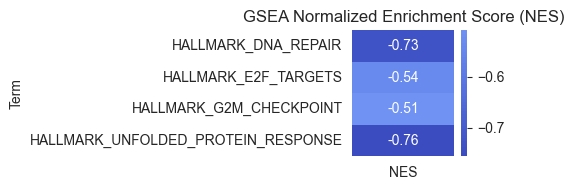

In [20]:
# Get the result table
df = gsea_res.res2d.copy()

# Optionally filter top terms
top_n = 20
df = df.sort_values("FDR q-val").head(top_n)

# Create a heatmap input — e.g., NES values
heatmap_data = df.pivot_table(
    index="Term",       # gene set name
    values="NES"        # or 'es', 'pval', or any other column
)
heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce')

# Plot
plt.figure(figsize=(5, len(heatmap_data) * 0.5))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0)
plt.title("GSEA Normalized Enrichment Score (NES)")
plt.tight_layout()
plt.show()